## Challenge:

The problem consists in predicting the probability of delay of the flights that land or take off from the airport of Santiago de Chile
(SCL). For that you will have a dataset using public and real data where each row corresponds to a flight that landed or took off
from SCL during 2017. The following information is available for each flight:

* **Fecha-I**: Scheduled date and time of the flight.  
* **Vlo-I**: Scheduled flight number.  
* **Ori-I**: Programmed origin city code.  
* **Des-I**: Programmed destination city code.  
* **Emp-I**: Scheduled flight airline code.  
* **Fecha-O**: Date and time of flight operation.  
* **Vlo-O**: Flight operation number of the flight.  
* **Ori-O**: Operation origin city code  
* **Des-O**: Operation destination city code.  
* **Emp-O**: Airline code of the operated flight.  
* **DIA**: Day of the month of flight operation.  
* **MES**: Number of the month of operation of the flight.  
* **AÑO**: Year of flight operation.  
* **DIANOM**: Day of the week of flight operation.  
* **TIPOVUELO**: Type of flight, I =International, N =National.  
* **OPERA**: Name of the airline that operates.  
* **SIGLAORI**: Name city of origin.  
* **SIGLADES**: Destination city name.  


In [5]:
#Lirerias útiles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msng
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('dataset_SCL.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


In [9]:
df.describe()

,DIA,MES,AÑO
count,68206.000000,68206.000000,68206.000000
mean,15.714790,6.622585,2017.000029
std,8.782886,3.523321,0.005415
min,1.000000,1.000000,2017.000000
25%,8.000000,3.000000,2017.000000
50%,16.000000,7.000000,2017.000000
75%,23.000000,10.000000,2017.000000
max,31.000000,12.000000,2018.000000


1. How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

### Destinos

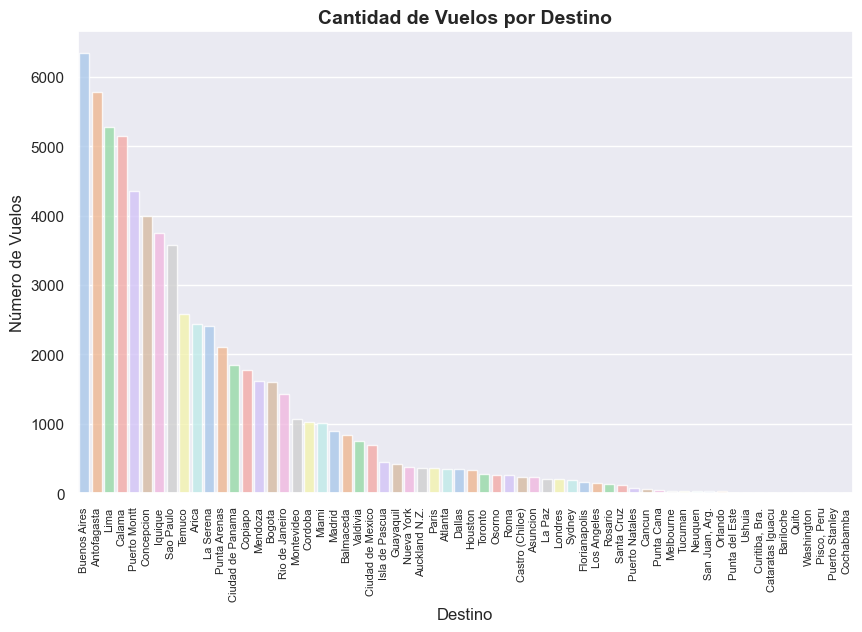

In [61]:
destinos = df['SIGLADES'].value_counts()

# Establecer el tamaño de la figura
plt.figure(figsize=(10, 6))

# Colores personalizados
colores = sns.color_palette('pastel')[:len(destinos)]

sns.barplot(destinos.index, destinos.values, palette=colores, alpha=0.8)

plt.title('Cantidad de Vuelos por Destino', fontsize=14, fontweight='bold')
plt.ylabel('Número de Vuelos', fontsize=12)
plt.xlabel('Destino', fontsize=12)

# Ajustar el tamaño de las etiquetas del eje x
plt.xticks(rotation=90, fontsize=8)

plt.show()

* *La mayoría de los destinos más visitados en los vuelos internacionales son las cápitales de los países más cercanos (excluyendo a Sao Paulo).*   
* *En el caso de los vuelos nacionales, estos están más inclinados hacia el sur de Chile donde destacan sectores mineros.*

### Tipos de Vuelo

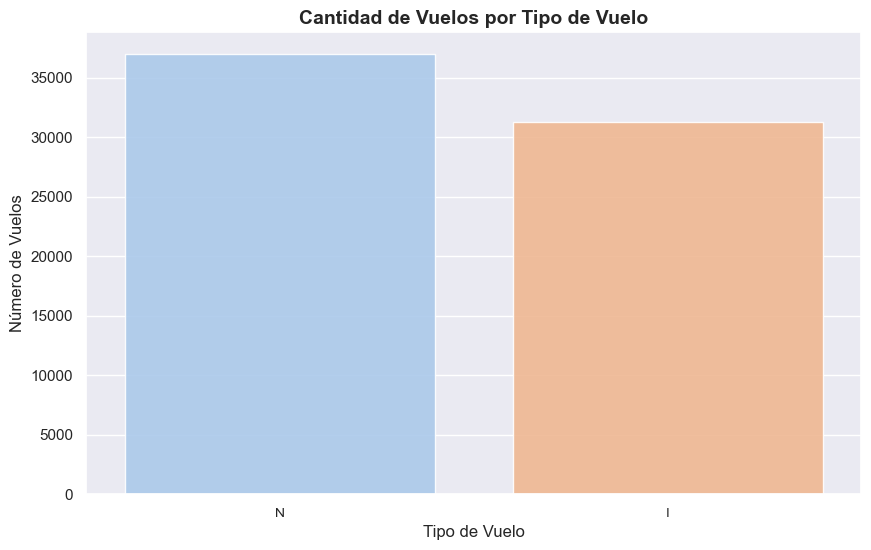

In [62]:
tipo_vuelo = df['TIPOVUELO'].value_counts()

# Establecer el tamaño de la figura
plt.figure(figsize=(10, 6))

# Colores personalizados
colores = sns.color_palette('pastel')[:len(tipo_vuelo)]

sns.barplot(tipo_vuelo.index, tipo_vuelo.values, palette=colores, alpha=0.9)

plt.title('Cantidad de Vuelos por Tipo de Vuelo', fontsize=14, fontweight='bold')
plt.ylabel('Número de Vuelos', fontsize=12)
plt.xlabel('Tipo de Vuelo', fontsize=12)

# Ajustar el tamaño de las etiquetas del eje x
plt.xticks(fontsize=10)

plt.show()

* *Existe una distribución similar entre vuelos Nacionales e internacionales.*

### Aerolinea

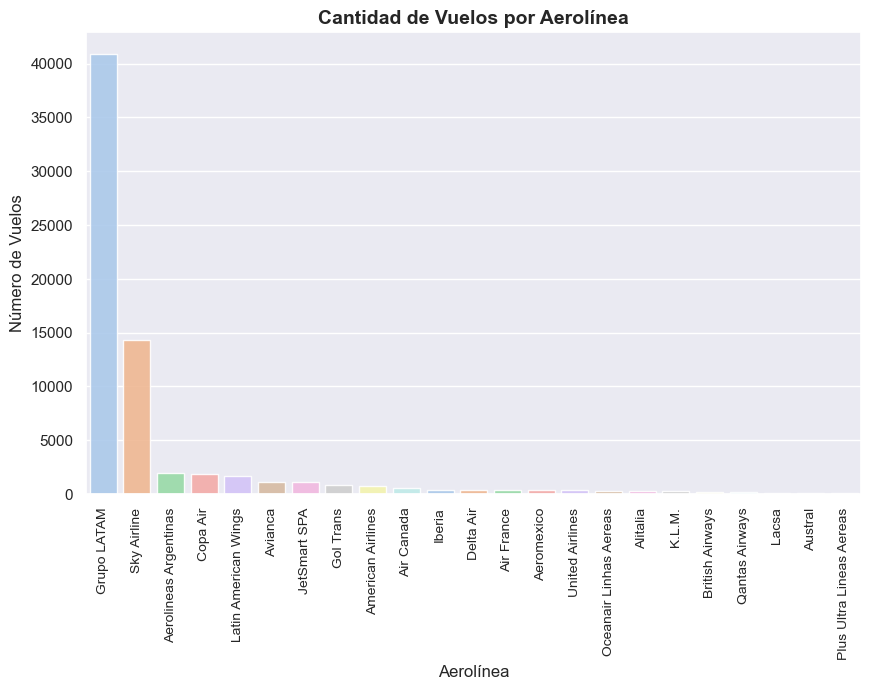

In [63]:
aerolinea = df['OPERA'].value_counts()

# Establecer el tamaño de la figura
plt.figure(figsize=(10, 6))

# Colores personalizados
colores = sns.color_palette('pastel')[:len(aerolinea)]

sns.barplot(aerolinea.index, aerolinea.values, palette=colores, alpha=0.9)

plt.title('Cantidad de Vuelos por Aerolínea', fontsize=14, fontweight='bold')
plt.ylabel('Número de Vuelos', fontsize=12)
plt.xlabel('Aerolínea', fontsize=12)

# Ajustar el tamaño de las etiquetas del eje x y rotarlas 90 grados para mayor legibilidad
plt.xticks(rotation=90, fontsize=10)

plt.show()

* *En este caso destaca la aerolínea "Grupo LATAM" con la mayoría de los vuelos, seguidos por "Sky Airline" que son las dos aerolíneas más grandes en . Las demás aerolíneas distribuyen de manera similar.*

### Periodos de Tiempo

#### Día del mes

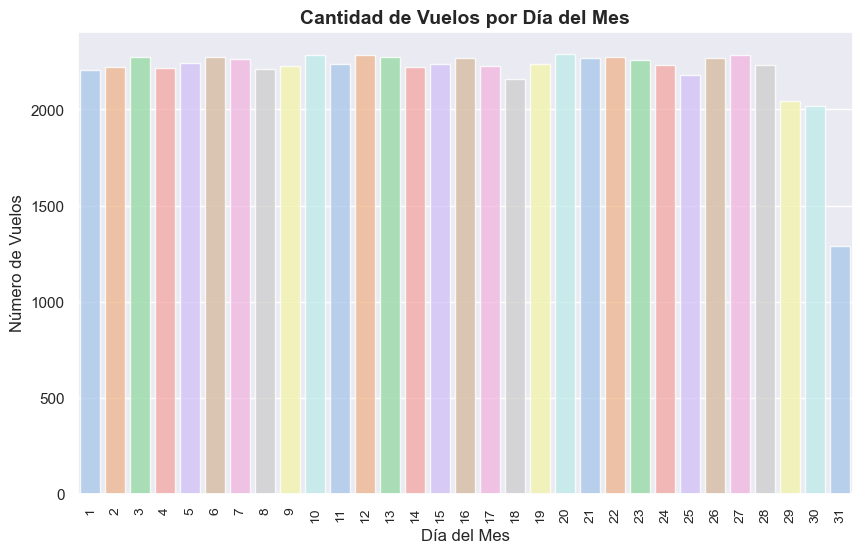

In [64]:
dia_mes = df['DIA'].value_counts()

# Establecer el tamaño de la figura
plt.figure(figsize=(10, 6))

# Colores personalizados
colores = sns.color_palette('pastel')[:len(dia_mes)]

sns.barplot(dia_mes.index, dia_mes.values, palette=colores, alpha=0.8)

plt.title('Cantidad de Vuelos por Día del Mes', fontsize=14, fontweight='bold')
plt.ylabel('Número de Vuelos', fontsize=12)
plt.xlabel('Día del Mes', fontsize=12)

# Ajustar el tamaño de las etiquetas del eje x y rotarlas 90 grados para mayor legibilidad
plt.xticks(rotation=90, fontsize=10)

plt.show()

* *El día del mes no parece ser un factor determinante en las decisiones de las personas en escoger cuando viajar. Siendo los días 29, 30 y 31 los días con menos vuelos, sin embargo, esto es trivial devido a que no todos los meses poseen esta cantidad de días.*

#### Meses

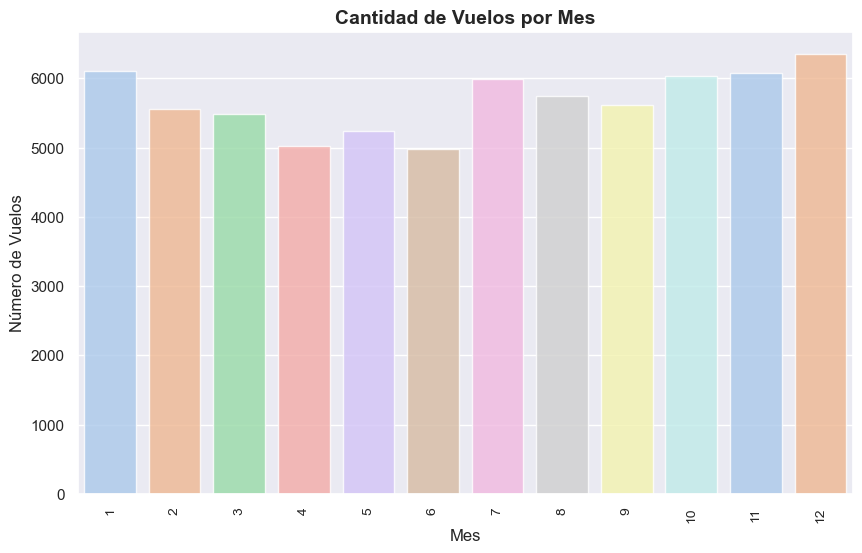

In [65]:
vuelos_mes = df['MES'].value_counts()

# Establecer el tamaño de la figura
plt.figure(figsize=(10, 6))

# Colores personalizados
colores = sns.color_palette('pastel')[:len(vuelos_mes)]

sns.barplot(vuelos_mes.index, vuelos_mes.values, palette=colores, alpha=0.8)

plt.title('Cantidad de Vuelos por Mes', fontsize=14, fontweight='bold')
plt.ylabel('Número de Vuelos', fontsize=12)
plt.xlabel('Mes', fontsize=12)

# Ajustar el tamaño de las etiquetas del eje x y rotarlas 90 grados para mayor legibilidad
plt.xticks(rotation=90, fontsize=10)

plt.show()

* *Los meses donde existen mayor cantidad de vuelos son en los periodos de verano y julio a causa de las vacaciones invierno*

#### Días de la Semana

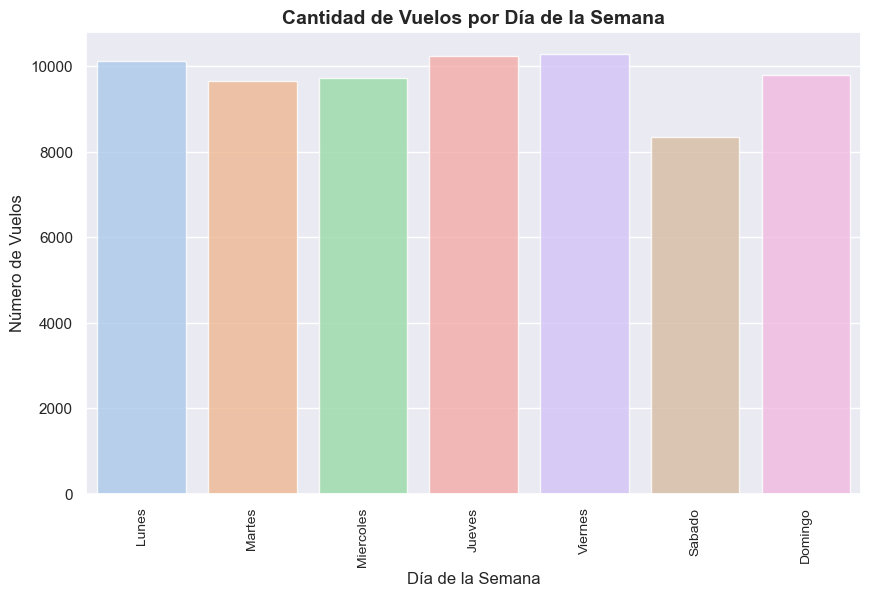

In [66]:
dianom = df['DIANOM'].value_counts()

# Ordenar los días de la semana en el orden deseado
dias = [dianom.index[2], dianom.index[5], dianom.index[4], dianom.index[1], dianom.index[0], dianom.index[6], dianom.index[3]]

# Obtener los valores correspondientes en el mismo orden
valores_dias = [dianom.values[2], dianom.values[5], dianom.values[4], dianom.values[1], dianom.values[0], dianom.values[6], dianom.values[3]]

# Establecer el tamaño de la figura
plt.figure(figsize=(10, 6))

# Colores personalizados
colores = sns.color_palette('pastel')[:len(dias)]

sns.barplot(dias, valores_dias, palette=colores, alpha=0.8)

plt.title('Cantidad de Vuelos por Día de la Semana', fontsize=14, fontweight='bold')
plt.ylabel('Número de Vuelos', fontsize=12)
plt.xlabel('Día de la Semana', fontsize=12)

# Ajustar el tamaño de las etiquetas del eje x y rotarlas 90 grados para mayor legibilidad
plt.xticks(rotation=90, fontsize=10)

plt.show()

* *En este caso el único que presenta una diferencia significativa respecto a los otros es el día Sábado, el cual es el día con menos salidas de vuelos desde Santiago.*

2. Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv:   

* high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.

In [30]:
from datetime import datetime

def high_season(fecha):
    fecha_año = int(fecha.split('-')[0])
    fecha = datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S')
    range1_min = datetime.strptime('15-Dec', '%d-%b').replace(year = fecha_año)
    range1_max = datetime.strptime('31-Dec', '%d-%b').replace(year = fecha_año)
    range2_min = datetime.strptime('1-Jan', '%d-%b').replace(year = fecha_año)
    range2_max = datetime.strptime('3-Mar', '%d-%b').replace(year = fecha_año)
    range3_min = datetime.strptime('15-Jul', '%d-%b').replace(year = fecha_año)
    range3_max = datetime.strptime('31-Jul', '%d-%b').replace(year = fecha_año)
    range4_min = datetime.strptime('11-Sep', '%d-%b').replace(year = fecha_año)
    range4_max = datetime.strptime('30-Sep', '%d-%b').replace(year = fecha_año)
    
    if ((fecha >= range1_min and fecha <= range1_max) or 
        (fecha >= range2_min and fecha <= range2_max) or 
        (fecha >= range3_min and fecha <= range3_max) or
        (fecha >= range4_min and fecha <= range4_max)):
        return 1
    else:
        return 0

In [31]:
df['high_season'] = df['Fecha-I'].apply(high_season)

In [32]:
df['high_season'].value_counts()

0    46174
1    22032
Name: high_season, dtype: int64

* min_diff : difference in minutes between Date-O and Date-I .

In [33]:
def min_diff(data):
    fecha_o = datetime.strptime(data['Fecha-O'], '%Y-%m-%d %H:%M:%S')
    fecha_i = datetime.strptime(data['Fecha-I'], '%Y-%m-%d %H:%M:%S')
    dif_min = ((fecha_o - fecha_i).total_seconds())/60
    return dif_min

In [34]:
df['min_diff'] = df.apply(min_diff, axis = 1)

* delay_15 : 1 if min_diff > 15, 0 if not.

In [35]:
df['delay_15'] = np.where(df['min_diff'] > 15, 1, 0)

* period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based onDate-I .

In [36]:
def get_period_day(fecha):
    fecha_time = datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S').time()
    mañana_min = datetime.strptime("05:00", '%H:%M').time()
    mañana_max = datetime.strptime("11:59", '%H:%M').time()
    tarde_min = datetime.strptime("12:00", '%H:%M').time()
    tarde_max = datetime.strptime("18:59", '%H:%M').time()
    noche_min1 = datetime.strptime("19:00", '%H:%M').time()
    noche_max1 = datetime.strptime("23:59", '%H:%M').time()
    noche_min2 = datetime.strptime("00:00", '%H:%M').time()
    noche_max2 = datetime.strptime("4:59", '%H:%M').time()
    
    if(fecha_time > mañana_min and fecha_time < mañana_max):
        return 'mañana'
    elif(fecha_time > tarde_min and fecha_time < tarde_max):
        return 'tarde'
    elif((fecha_time > noche_min1 and fecha_time < noche_max1) or
         (fecha_time > noche_min2 and fecha_time < noche_max2)):
        return 'noche'

In [37]:
df['period_day'] = df['Fecha-I'].apply(get_period_day)

In [38]:
df[['high_season','min_diff','delay_15','period_day']].to_csv('synthetic_features.csv', index = False)

3. What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight? What variables would you expect to have the most influence in predicting delays?

* What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight?

* What variables would you expect to have the most influence in predicting delays?

4. Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay. Feel free to generate additional variables and/or supplement with external variables

5. Evaluate model performance in the predictive task across each model that you trained. Define and justify what metrics you used to assess model performance. Pick the best trained model and evaluate the following: What variables were the most influential in the prediction task? How could you improve the Performance?